In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import scipy.stats

model inference gist: https://gist.github.com/yqngzh/9c5a63ad2a1dba05f681323d23fc5feb

In [2]:
df_v1 = pd.read_csv("/Users/yzhang/development/yzhang-adhoc-analysis/2024Q1_semantic_relevance/v1_model_preds.csv")
df_v2 = pd.read_csv("/Users/yzhang/development/yzhang-adhoc-analysis/2024Q1_semantic_relevance/v2_model_preds.csv")

In [3]:
df_v1.head()

,query,listingId,title,gold_label,teacher_label,teacher_score_1,teacher_score_4,integration_label,integration_score_1,integration_score_4,retrieval_label,retrieval_score
0,royal purple,184185194,10 Pcs 8-10&quot; 10-12&quot; 12-14&quot; 14-1...,1,4,0.214370,0.682899,4,0.110600,0.615366,4.0,0.452526
1,royal purple,227662738,100 pcs purple ostrich feather plumes for wedd...,4,4,0.194096,0.720645,4,0.147551,0.615842,4.0,0.467745
2,royal purple,651859700,"Royal Purple Hand Spun Merino Wool, DK / Worst...",4,4,0.001926,0.996316,4,0.021699,0.933988,NaN,NaN
3,royal purple,731666840,TRICORN &quot;BATHORY&quot; Royal Purple Hat f...,4,4,0.025503,0.970031,4,0.044830,0.932745,NaN,NaN
4,royal purple,881161512,Fanya Kaftan Dress ( Royal Dark purple )// kaf...,4,4,0.026000,0.965567,4,0.037522,0.936151,NaN,NaN


In [4]:
# score 4 correlation
print(scipy.stats.pearsonr(df_v1.teacher_score_4, df_v1.integration_score_4))
print(scipy.stats.spearmanr(df_v1.teacher_score_4, df_v1.integration_score_4))

# 1 - score1 correlation
print(scipy.stats.pearsonr(1.0 - df_v1.teacher_score_1, 1.0 - df_v1.integration_score_1))
print(scipy.stats.spearmanr(1.0 - df_v1.teacher_score_1, 1.0 - df_v1.integration_score_1))

PearsonRResult(statistic=0.7561285829427846, pvalue=0.0)
SignificanceResult(statistic=0.829650072460006, pvalue=0.0)
PearsonRResult(statistic=0.7421001957723388, pvalue=0.0)
SignificanceResult(statistic=0.8539624487860884, pvalue=0.0)


In [5]:
def compute_fpr_fnr(label_vec, pred_scores, thresholds_vec):
    fpr_vec = []
    fnr_vec = []
    for thresh in thresholds_vec:
        pred_label = [4 if x > thresh else 1 for x in pred_scores]
        tn, fp, fn, tp = confusion_matrix(label_vec, pred_label).ravel()
        curr_fpr = fp / (fp + tn)
        curr_fnr = fn / (fn + tp)
        fpr_vec.append(curr_fpr)
        fnr_vec.append(curr_fnr)
    return fpr_vec, fnr_vec

In [6]:
THRESHOLDS = [x / 100.0 for x in range(0, 101, 2)]   

# V1 eval data

In [9]:
## gold label
v1_gold_4vr = df_v1.gold_label.apply(lambda x: 4 if x == 4 else 1)  # 4 vs rest binary label
v1_gold_4vr.value_counts()

4    2190
1     715
Name: gold_label, dtype: int64

In [10]:
# use score4
teacher_score4_fpr, teacher_score4_fnr = compute_fpr_fnr(v1_gold_4vr, df_v1.teacher_score_4, THRESHOLDS)
integ_score4_fpr, integ_score4_fnr = compute_fpr_fnr(v1_gold_4vr, df_v1.integration_score_4, THRESHOLDS)

# use 1 - score1
teacher_score1_fpr, teacher_score1_fnr = compute_fpr_fnr(v1_gold_4vr, 1.0 - df_v1.teacher_score_1, THRESHOLDS)
integ_score1_fpr, integ_score1_fnr = compute_fpr_fnr(v1_gold_4vr, 1.0 - df_v1.integration_score_1, THRESHOLDS)

In [11]:
v1_score4_df = pd.DataFrame({
    "thresholds": THRESHOLDS,
    "teacher_FPR": teacher_score4_fpr,
    "teacher_FNR": teacher_score4_fnr,
    "integration_FPR": integ_score4_fpr,
    "integration_FNR": integ_score4_fnr,
})
v1_score4_df

,thresholds,teacher_FPR,teacher_FNR,integration_FPR,integration_FNR
0,0.00,1.000000,0.000000,1.000000,0.000000
1,0.02,0.995804,0.000000,1.000000,0.000000
2,0.04,0.945455,0.000457,1.000000,0.000000
3,0.06,0.925874,0.002283,1.000000,0.000000
4,0.08,0.911888,0.002740,1.000000,0.000000
5,0.10,0.897902,0.003196,1.000000,0.000000
6,0.12,0.876923,0.004110,1.000000,0.000000
7,0.14,0.858741,0.005479,0.995804,0.000457
8,0.16,0.840559,0.007306,0.993007,0.002283
9,0.18,0.822378,0.010959,0.984615,0.003196


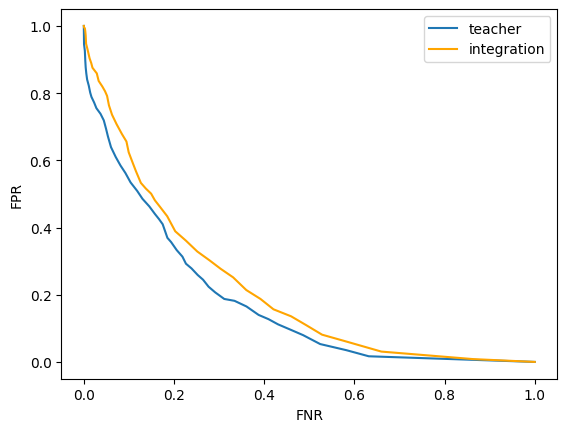

In [12]:
plt.plot(v1_score4_df.teacher_FNR, v1_score4_df.teacher_FPR, label="teacher")
plt.plot(v1_score4_df.integration_FNR, v1_score4_df.integration_FPR, label="integration", color="orange")

plt.xlabel("FNR")
plt.ylabel("FPR")
plt.legend()
plt.show()

In [13]:
v1_score1_df = pd.DataFrame({
    "thresholds": THRESHOLDS,
    "teacher_FPR": teacher_score1_fpr,
    "teacher_FNR": teacher_score1_fnr,
    "integration_FPR": integ_score1_fpr,
    "integration_FNR": integ_score1_fnr,
})
v1_score1_df

,thresholds,teacher_FPR,teacher_FNR,integration_FPR,integration_FNR
0,0.00,1.000000,0.000000,1.000000,0.000000
1,0.02,1.000000,0.000000,1.000000,0.000000
2,0.04,0.981818,0.000000,1.000000,0.000000
3,0.06,0.949650,0.000457,1.000000,0.000000
4,0.08,0.927273,0.000913,1.000000,0.000000
5,0.10,0.918881,0.001826,1.000000,0.000000
6,0.12,0.911888,0.001826,1.000000,0.000000
7,0.14,0.904895,0.003196,1.000000,0.000000
8,0.16,0.893706,0.004566,1.000000,0.000000
9,0.18,0.882517,0.004566,1.000000,0.000000


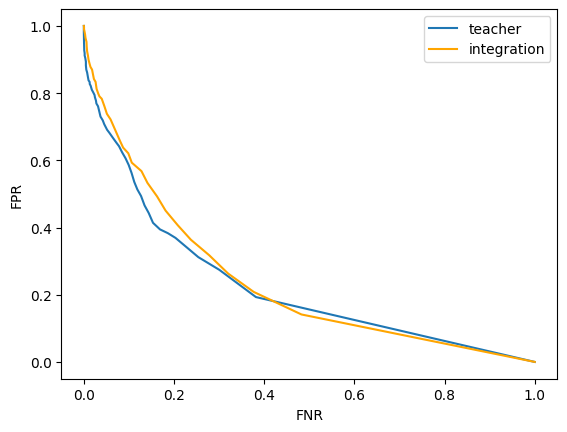

In [14]:
plt.plot(v1_score1_df.teacher_FNR, v1_score1_df.teacher_FPR, label="teacher")
plt.plot(v1_score1_df.integration_FNR, v1_score1_df.integration_FPR, label="integration", color="orange")

plt.xlabel("FNR")
plt.ylabel("FPR")
plt.legend()
plt.show()

# V2 data

In [15]:
v2_gold_4vr = df_v2.gold_label.apply(lambda x: 4 if x == 4 else 1)  # 4 vs rest binary label
v2_gold_4vr.value_counts()

4    16622
1    13334
Name: gold_label, dtype: int64

In [21]:
# use score4
teacher_score4_fpr, teacher_score4_fnr = compute_fpr_fnr(v2_gold_4vr, df_v2.teacher_score_4, THRESHOLDS)
integ_score4_fpr, integ_score4_fnr = compute_fpr_fnr(v2_gold_4vr, df_v2.integration_score_4, THRESHOLDS)

# use 1 - score1
teacher_score1_fpr, teacher_score1_fnr = compute_fpr_fnr(v2_gold_4vr, 1.0 - df_v2.teacher_score_1, THRESHOLDS)
integ_score1_fpr, integ_score1_fnr = compute_fpr_fnr(v2_gold_4vr, 1.0 - df_v2.integration_score_1, THRESHOLDS)

In [22]:
v2_score4_df = pd.DataFrame({
    "thresholds": THRESHOLDS,
    "teacher_FPR": teacher_score4_fpr,
    "teacher_FNR": teacher_score4_fnr,
    "integration_FPR": integ_score4_fpr,
    "integration_FNR": integ_score4_fnr,
})
v2_score4_df

,thresholds,teacher_FPR,teacher_FNR,integration_FPR,integration_FNR
0,0.00,1.000000,0.000000,1.000000,0.000000
1,0.02,0.986351,0.000180,1.000000,0.000000
2,0.04,0.960252,0.000662,1.000000,0.000000
3,0.06,0.936478,0.001745,0.999850,0.000000
4,0.08,0.913154,0.003309,0.999250,0.000000
5,0.10,0.890055,0.004933,0.997750,0.000060
6,0.12,0.867557,0.007219,0.994375,0.000241
7,0.14,0.843783,0.009385,0.987551,0.000481
8,0.16,0.820834,0.012333,0.980726,0.000963
9,0.18,0.797810,0.015582,0.971576,0.001805


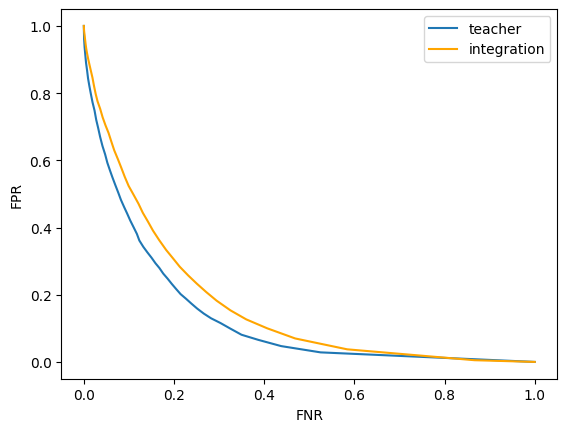

In [23]:
plt.plot(v2_score4_df.teacher_FNR, v2_score4_df.teacher_FPR, label="teacher")
plt.plot(v2_score4_df.integration_FNR, v2_score4_df.integration_FPR, label="integration", color="orange")

plt.xlabel("FNR")
plt.ylabel("FPR")
plt.legend()
plt.show()

In [24]:
v2_score1_df = pd.DataFrame({
    "thresholds": THRESHOLDS,
    "teacher_FPR": teacher_score1_fpr,
    "teacher_FNR": teacher_score1_fnr,
    "integration_FPR": integ_score1_fpr,
    "integration_FNR": integ_score1_fnr,
})
v2_score1_df

,thresholds,teacher_FPR,teacher_FNR,integration_FPR,integration_FNR
0,0.00,1.000000,0.000000,1.000000,0.000000
1,0.02,0.994975,0.000060,1.000000,0.000000
2,0.04,0.976226,0.000301,1.000000,0.000000
3,0.06,0.958827,0.000662,1.000000,0.000000
4,0.08,0.944053,0.001384,1.000000,0.000000
5,0.10,0.929054,0.002045,0.999850,0.000000
6,0.12,0.912179,0.002948,0.999325,0.000060
7,0.14,0.897855,0.004452,0.998650,0.000060
8,0.16,0.882781,0.005595,0.996550,0.000060
9,0.18,0.867482,0.006798,0.993175,0.000241


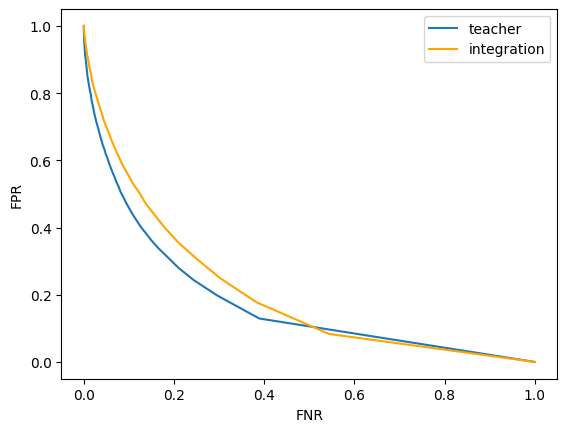

In [25]:
plt.plot(v2_score1_df.teacher_FNR, v2_score1_df.teacher_FPR, label="teacher")
plt.plot(v2_score1_df.integration_FNR, v2_score1_df.integration_FPR, label="integration", color="orange")

plt.xlabel("FNR")
plt.ylabel("FPR")
plt.legend()
plt.show()